In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [38]:
seed = 0
rng = np.random.default_rng(seed)

d = 30
L = 50
eps = 0.01

n_train = 10
n_test = 50

l = 30
T = 100

def sample_rotation_near_identity(d, eps, rng):
    M = rng.standard_normal((d, d)) / np.sqrt(d)
    S = (M - M.T).astype(np.float64)
    I = np.eye(d, dtype=np.float64)
    O = np.linalg.solve(I - eps * S, I + eps * S)  # (I - eps * S)^{-1}(I + eps * S) is orthogonal
    return O


def normalize_to_sqrt_d(x):
    nrm = np.linalg.norm(x) + 1e-12
    return x * (math.sqrt(d) / nrm)


def generate_sequence(d, L, eps, rng):
    A = sample_rotation_near_identity(d, eps, rng)
    x0 = normalize_to_sqrt_d(rng.standard_normal(d).astype(np.float32))
    xs = [x0]
    for _ in range(L):
        xs.append(A @ xs[-1])
    y = xs[-1]
    for _ in range(T - L):
        y = A @ y
    return np.stack(xs, axis=0), A, y


def build_dataset(n, d, L, l, eps, rng):
    X_list, y_list, A_list, x0_list = [], [], [], []
    for _ in range(n):
        X, A, y = generate_sequence(d, L, eps, rng)
        X_list.append(X.astype(np.float32))
        y_list.append(y.astype(np.float32))
        A_list.append(A.astype(np.float32))
        x0_list.append(X[0].astype(np.float32))
    return np.stack(X_list), np.stack(y_list), A_list, x0_list


Xtr, ytr, Atr, x0tr = build_dataset(n_train, d, L, l, eps, rng)
Xte, yte, Ate, x0te = build_dataset(n_test, d, L, l, eps, rng)

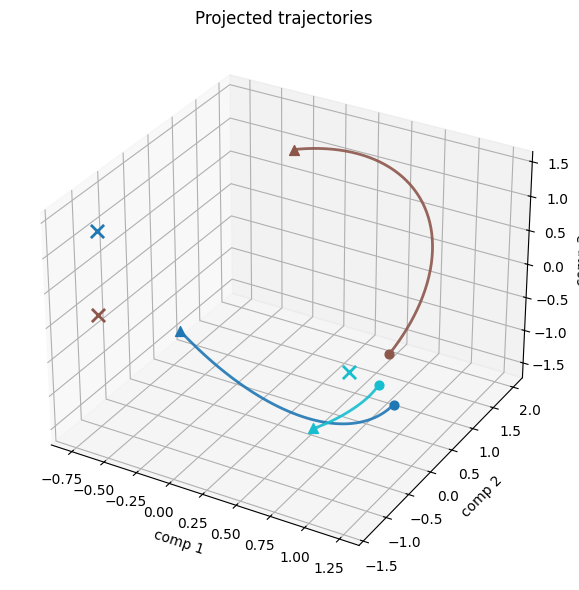

In [39]:
def visualize_sequences_3d(Xtr, ytr, rng, n_to_plot=3, figsize=(7,6), linewidth=2.0, alpha_traj=0.9):

    Xtr_plot = Xtr[:n_to_plot]
    ytr_plot = ytr[:n_to_plot]
    
    d = Xtr_plot[0].shape[1]
    
    M = rng.standard_normal((d, 3))
    W, _ = np.linalg.qr(M)
    W = W[:, :3]  # (d, 3)
    
    proj_Xtr_plot = [s @ W for s in Xtr_plot]
    proj_ytr_plot = [s @ W for s in ytr_plot]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    cmap_base = mpl.colormaps.get_cmap('tab10')
    colors = cmap_base(np.linspace(0, 1, n_to_plot))

    for j in range(n_to_plot):
        
        P = proj_Xtr_plot[j]          # (L, 3)
        y = proj_ytr_plot[j]          # (3,)

        # trajectory through the l context tokens
        ax.plot(P[:,0], P[:,1], P[:,2],
                '-', lw=linewidth, alpha=alpha_traj, color=colors[j])

        # start and end of the context window
        ax.scatter(P[0,0],  P[0,1],  P[0,2],  s=40, color=colors[j], marker='o')
        ax.scatter(P[-1,0], P[-1,1], P[-1,2], s=50, color=colors[j], marker='^')

        # target y as a cross (bigger, with edge)
        ax.scatter(y[0], y[1], y[2],
                   s=90, marker='x', linewidths=2.0, color=colors[j])

    ax.set_title(f"Projected trajectories")
    ax.set_xlabel("comp 1"); ax.set_ylabel("comp 2"); ax.set_zlabel("comp 3")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


visualize_sequences_3d(Xtr, ytr, rng)

# Bro sorry I did not check carefully this, I kinda trusted the ability of GPT-5 in doing derivatives...

* per sample $b$: $X_b\in\mathbb{R}^{l\times d}$ (last $l$ tokens), $y_b\in\mathbb{R}^d$
* parameters: $\theta\in\mathbb{R}^l$, $\Theta\in\mathbb{R}^{d\times d}$
* intermediate: $z_b = X_b^\top \theta \in\mathbb{R}^d$
* prediction: $\hat y_b = \Theta, z_b \in\mathbb{R}^d$
* residual: $r_b = \hat y_b - y_b \in\mathbb{R}^d$

The empirical loss is
$$
\mathcal L(\Theta,\theta)
=\frac{1}{n}\sum_{b=1}^n \|r_b\|_2^2.
$$

---

# Gradient w.r.t. $\Theta$ ($d\times d$)

For a single sample $b$,
$$
r_b(\Theta)=\Theta z_b - y_b, \qquad
\frac{\partial}{\partial \Theta} \|r_b\|_2^2 = 2 (\Theta z_b - y_b) z_b^\top \in\mathbb{R}^{d\times d}.
$$

Averaging over $b$:
$$
\boxed{
\nabla_{\Theta}\mathcal L = \frac{1}{n}\sum_{b=1}^n r_b z_b^\top
}
$$

Matrix form (stack $R=[r_b]_{b=1}^n \in \mathbb{R}^{n\times d}$, $Z=[z_b]_{b=1}^n\in\mathbb{R}^{n\times d}$):

$$
\boxed{
\nabla_{\Theta}\mathcal L
= \frac{1}{n} R^\top Z
}
$$

**Shapes:** $R^\top Z$ is $d \times d$.

---

# Gradient w.r.t. $\theta$ ($l$)

Chain rule: $r_b(\theta)=\Theta X_b^\top \theta - y_b$.

* Jacobian of $r_b$ w.r.t. $\theta$:
  $$
  J_b = \frac{\partial r_b}{\partial \theta}
  = \Theta X_b^\top  \in\mathbb{R}^{d\times l}.
  $$
* Per-sample contribution:
  $$
  \frac{\partial}{\partial \theta} \|r_b\|_2^2
  = 2, J_b^\top r_b
  = 2, X_b \Theta^\top r_b \in\mathbb{R}^{l}.
  $$

Averaging over $b$:
$$
\boxed{
\nabla_{\theta}\mathcal L
= \frac{1}{n}\sum_{b=1}^n X_b \Theta^\top r_b
}
$$

which elementwise can be written as:
$$
\boxed{
\big[\nabla_{\theta}\mathcal L\big]_k
= \frac{2}{n} \sum_{b=1}^n \sum_{j=1}^d X_b[k,j] \big(\Theta^\top r_b\big)_j \qquad k=1,\dots,l.
}
$$

In [40]:
def forward_predict(X, Theta, theta):
    X_theta = (X[:, -l:, :] * theta[None, :, None]).sum(axis=1)
    X_next = X_theta @ Theta.T  # (n, d)
    return X_next, X_theta


def compute_loss_and_grads(X, y, Theta, theta):
    n = X.shape[0]
    X_next, X_theta = forward_predict(X, Theta, theta)

    yhat = X_next  # here the next token prediction is already the prediction for the label

    residual = yhat - y  # (n, d)
    loss = np.mean(np.sum(residual ** 2, axis=1)) / 2

    grad_Theta = (residual.T @ X_theta) / n

    g = residual @ Theta  # (n, d)

    grad_theta = np.zeros_like(theta)
    for k in range(l):
        grad_theta[k] = np.sum(X[:, k, :] * g) / n
    
    return loss, grad_Theta, grad_theta

In [43]:
Theta = np.eye(d, dtype=np.float32)
theta = np.zeros(l)

num_batches = math.ceil(n_train / batch_size)
train_curve, test_curve = [], []

train_Theta = False
epochs = 10000
batch_size = n_train

for epoch in range(epochs):
    
    perm = rng.permutation(n_train)
    Xtr_shuf, ytr_shuf = Xtr[perm], ytr[perm]
    epoch_loss = 0.0

    for b in range(num_batches):
        s = b * batch_size
        e = min((b + 1) * batch_size, n_train)
        xb, yb = Xtr_shuf[s:e], ytr_shuf[s:e]  # xb:(B, l, d), yb:(B, d)

        loss, gT, gt = compute_loss_and_grads(xb, yb, Theta, theta)

        lr = 5e-4

        if train_Theta:
            Theta -= lr * gT
            
        theta -= lr * gt

        epoch_loss += loss * (e - s)

    epoch_loss /= n_train

    if (epoch + 1) % 200 == 0 or epoch == 1:
        yhat_te, _ = forward_predict(Xte, Theta, theta)
        residual_te = yhat_te - yte
        test_loss = np.mean(np.sum(residual_te ** 2, axis=1)) / 2
        train_curve.append(epoch_loss)
        test_curve.append(test_loss)
        print(f"epoch {epoch+1:3d} | train MSE {epoch_loss:.6f} | test MSE {test_loss:.6f}")

epoch   2 | train MSE 14.968744 | test MSE 14.893911
epoch 200 | train MSE 11.920877 | test MSE 12.053153
epoch 400 | train MSE 11.334571 | test MSE 11.454890
epoch 600 | train MSE 10.826108 | test MSE 10.932136
epoch 800 | train MSE 10.362698 | test MSE 10.456547
epoch 1000 | train MSE 9.939705 | test MSE 10.023288
epoch 1200 | train MSE 9.553304 | test MSE 9.628298
epoch 1400 | train MSE 9.200055 | test MSE 9.267926
epoch 1600 | train MSE 8.876859 | test MSE 8.938888
epoch 1800 | train MSE 8.580924 | test MSE 8.638226
epoch 2000 | train MSE 8.309731 | test MSE 8.363277
epoch 2200 | train MSE 8.061009 | test MSE 8.111640
epoch 2400 | train MSE 7.832710 | test MSE 7.881151
epoch 2600 | train MSE 7.622982 | test MSE 7.669862
epoch 2800 | train MSE 7.430153 | test MSE 7.476011
epoch 3000 | train MSE 7.252715 | test MSE 7.298010
epoch 3200 | train MSE 7.089301 | test MSE 7.134426
epoch 3400 | train MSE 6.938676 | test MSE 6.983964
epoch 3600 | train MSE 6.799723 | test MSE 6.845452
epoch 


Final test MSEs
 - Trained linear AR(l) model:   5.230561
 - Last-token baseline:          21.533928


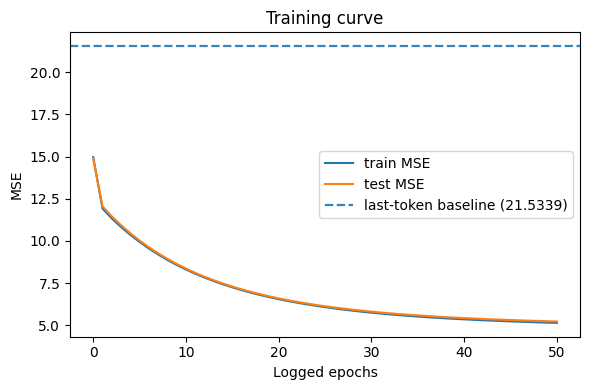

In [44]:
# --- trivial "last-token" baseline on the test set ---
yhat_last = Xte[:, -1, :] # (n_test, d) — just copy the last context token
baseline_mse = np.mean(np.sum((yhat_last - yte) ** 2, axis=1)) / 2

print("\nFinal test MSEs")
print(f" - Trained linear AR(l) model:   {test_curve[-1]:.6f}")
print(f" - Last-token baseline:          {baseline_mse:.6f}")

# --- plot train/test curves + horizontal baseline line ---
plt.figure(figsize=(6,4))
xs = np.arange(len(train_curve))
plt.plot(xs, train_curve, label="train MSE")
plt.plot(xs, test_curve, label="test MSE")

# horizontal line at the baseline MSE
plt.axhline(baseline_mse, linestyle="--", linewidth=1.6, alpha=0.9,
            label=f"last-token baseline ({baseline_mse:.4f})")

plt.xlabel("Logged epochs")
plt.ylabel("MSE")
plt.title("Training curve")
plt.legend()
plt.tight_layout()
plt.show()

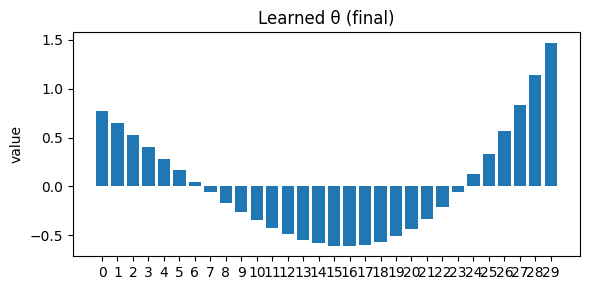

In [46]:
plt.figure(figsize=(6,3))
idx = np.arange(l)
plt.bar(idx, theta, width=0.8)
plt.xticks(idx, [k for k in range(l)])
plt.ylabel("value")
plt.title("Entries of θ (final)")
plt.tight_layout()
plt.show()

Ok what is the take away here? Not sure, one should try some regimes and see what is going on. One think that I am not sure I like of this model is that the optimal $\Theta$ in this case should be the identity, so not sure why we would introduce it as a trainable parameter...